In [1]:
import json
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from music21 import *
from tqdm import tqdm
import pandas as pd
import seaborn as sns

### Import Scores

In [2]:
#@title get scores
def get_scores(folder_path):
    mxl_files = {}

    # Iterate over files in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is an MXL file
        if file_name.endswith('.mxl'):
            # Add the file name as key and its path as value to the dictionary
            mxl_files[file_name] = file_path

    mxl_files = dict(sorted(mxl_files.items()))
    return mxl_files

In [3]:
# Create a path relative to the current directory
folder_path = 'scores'

mxl_files = get_scores(folder_path)

# Print the dictionary containing MXL file names and their paths
for file_name, file_path in mxl_files.items():
    print(f"File Name: {file_name}")

File Name: Bassit_Iraq_Ajam.mxl
File Name: Btaihi_Iraq_Ajam.mxl
File Name: Btayhi_Iraq_Ajam.mxl
File Name: Quddam_Iraq_Ajam(1).mxl
File Name: Quddam_Iraq_Ajam(2).mxl
File Name: Quddam_Iraq_Ajam.mxl
File Name: Quddam_Iraq_Ajam_Lasamir.mxl


### Select Score and Extract important Metadata

In [107]:
filename = 'Btaihi_Iraq_Ajam.mxl' # Choose from list above

In [108]:
score = converter.parse(mxl_files[filename])

In [109]:
p = score.parts[0]
measures = p.getElementsByClass(stream.Measure).stream()

In [110]:
# Dictionary to store text expressions with measure number as key
text_expressions_dict = {}

# Iterate over all measures
for measure_number, measure in enumerate(measures):
    # Check if the measure contains a TextExpression
    for element in measure.elements:
        if isinstance(element, expressions.TextExpression):
            # If TextExpression found, record the string in the dictionary
            text_content = element.content
            text_expressions_dict[measure_number] = text_content

# Print the dictionary
print('{Measure no. : Staff text} = ', text_expressions_dict)

{Measure no. : Staff text} =  {0: 'Tawchiya', 123: 'Mshalia', 152: 'Futintu', 231: 'accel.', 234: 'Billah ya saqi', 304: 'accel.', 309: 'Ya qawmi hajarni', 393: 'Ya qalbi man yuridek', 489: 'Charibna', 569: 'accel.', 573: 'Ya warda zawan', 610: 'accel.', 613: 'Qadru al-Kalam', 645: 'MAWWAL', 646: 'Man la raqad', 753: 'accel.', 763: 'Jumula zahri', 818: 'accel.', 823: 'Hada elyawm', 919: 'Atani mina', 979: 'Aya fadiha elbadri'}


### Analysis


In [121]:
centos = [['B', 'A', 'G'],
          ['E', 'D', 'C'],
          ['E', 'F#', 'G'],
          ['F', 'E', 'D'],
          ['G', 'F#', 'E', 'D']]

# excluded [['A', 'G', 'B'],['C', 'D', 'E']]

In [122]:
def search_for_centos(score, centos_list):
    """
    Search for given melodic centos in a MusicXML file and retrieve their occurrences.

    Parameters:
    - musicxml_file (str): Parsed music xml file
    - centos_list (list): List of melodic centos represented as lists of pitch names or note objects.

    Returns:
    - list: List of dictionaries, each containing information about a found cento, its position, melodic contour, rhythmic values, and other details.
    """

    # List to store information about found centos
    found_centos_info = []

    # Iterate over the parts in the score
    for part in score.parts:
        # Iterate over measures in each part
        for measure_number, measure in enumerate(part.getElementsByClass('Measure'), start=1):
            # Extract notes from each measure
            notes = measure.getElementsByClass("Note").flatten()

            # Iterate over each cento in the centos_list
            for cento in centos_list:
                cento_length = len(cento)

                # Iterate over indices to search for the cento
                for i in range(len(notes) - cento_length + 1):
                    # Check if the current sequence of notes matches the cento
                    #avoid using nameWIthOctave() method to get the centos regardless of the octave they appear in
                    if [note.pitch.name for note in notes[i:i + cento_length]] == cento:
                        # Extract melodic and rhythmic information
                        melodic_contour = cento
                        rhythmic_values = [note.quarterLength for note in notes[i:i + cento_length]]

                        # Store information about the found cento in a dictionary
                        cento_info = {
                            'cento': cento,
                            'position': {
                                'measure': measure_number,
                                'start_index': i,
                                'end_index': i + cento_length - 1
                            },
                            'rhythmic_values': rhythmic_values,
                        }
                        found_centos_info.append(cento_info)

    return found_centos_info

In [123]:
found_centos_info = search_for_centos(score, centos)

In [124]:
# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(found_centos_info)

# Convert cento lists to tuples
df['cento'] = df['cento'].apply(tuple)

print('Total number of centos found: ',len(df))

Total number of centos found:  364


In [125]:
df.head()

,cento,position,rhythmic_values
0,"(E, F#, G)","{'measure': 24, 'start_index': 0, 'end_index': 2}","[0.5, 0.5, 0.5]"
1,"(E, F#, G)","{'measure': 49, 'start_index': 0, 'end_index': 2}","[0.5, 0.5, 0.5]"
2,"(E, F#, G)","{'measure': 124, 'start_index': 0, 'end_index'...","[0.25, 0.25, 0.25]"
3,"(G, F#, E, D)","{'measure': 129, 'start_index': 0, 'end_index'...","[0.5, 0.5, 0.5, 1.0]"
4,"(B, A, G)","{'measure': 132, 'start_index': 2, 'end_index'...","[0.25, 0.5, 1.0]"


### Cento counts across score

In [126]:
# Find cento counts using value_counts()
cento_counts = df['cento'].value_counts()

# Display the counts of each cento
print("Cento Counts:")
print(cento_counts)

Cento Counts:
cento
(B, A, G)        91
(F, E, D)        88
(E, D, C)        85
(E, F#, G)       84
(G, F#, E, D)    16
Name: count, dtype: int64


### Calculate distribution of centos over measures

In [127]:
unique_centos = cento_counts.index.tolist()

# Initialize a new DataFrame with rows representing the unique centos and columns representing the total number of measures
total_measures = len(measures)
cento_count_df = pd.DataFrame(0, index=unique_centos, columns=range(1, total_measures+1))

In [128]:
# Iterate over each row in the DataFrame df
for index, row in df.iterrows():
    # Extract cento tuple and measure number from the current row
    cento = row['cento']
    measure = row['position']['measure']

    # Update the corresponding cell in cento_count_df
    cento_count_df.at[cento, measure] += 1
    
print('Done! Ready to plot')


Done! Ready to plot


### Plot

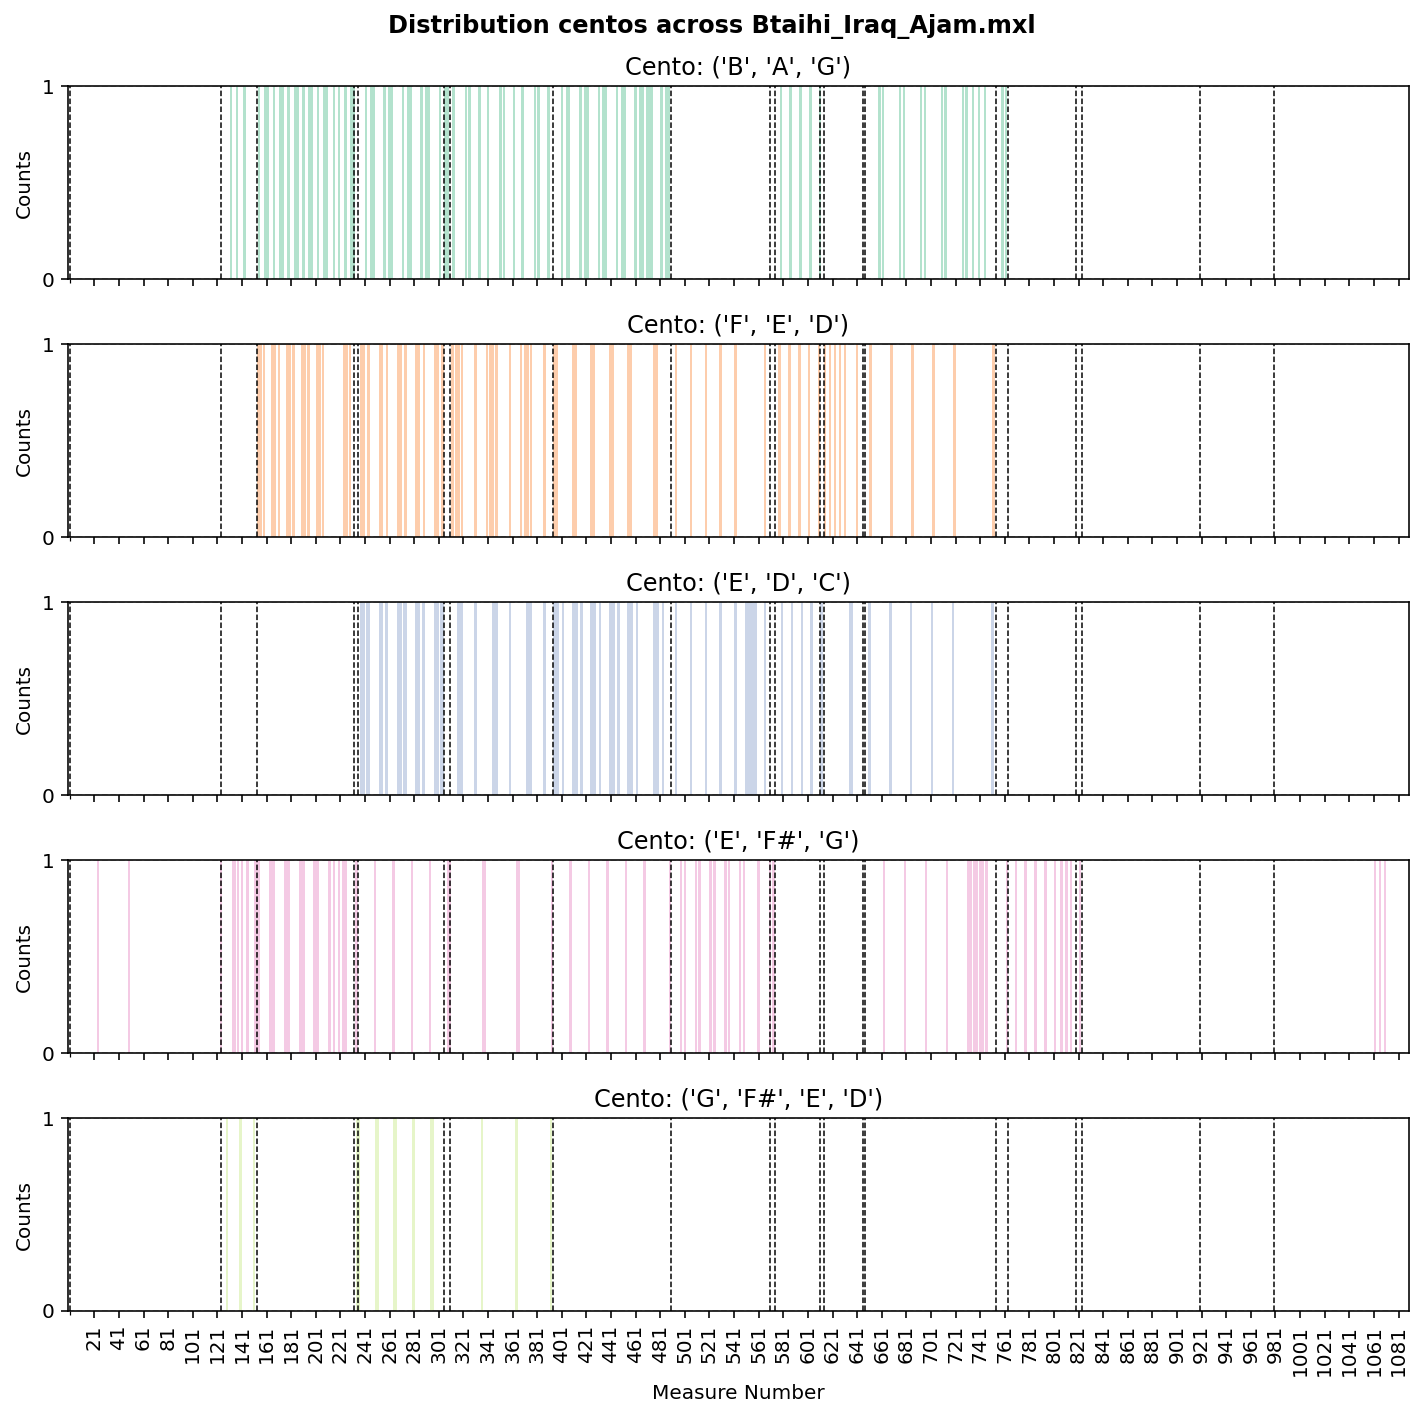

In [129]:
# Calculate the maximum count across all centos in cento_count_df
max_count = cento_count_df.values.max()

palette = plt.get_cmap('Pastel2').colors

# Check if there is only one cento
if len(cento_count_df) == 1:
    # Create a single subplot
    fig, axs = plt.subplots(1, 1, figsize=(10, 2))
    axs = [axs]  # Convert to a list for compatibility with the rest of the code
else:
    # Create subplots for each cento
    fig, axs = plt.subplots(len(cento_count_df), 1, figsize=(10, 2 * len(cento_count_df)), sharex=True)

# Iterate over each cento in cento_count_df
for i, (cento, counts) in enumerate(cento_count_df.iterrows()):
    # Plot counts for the current cento
    counts.plot(kind='bar', ax=axs[i], color=palette[i], width=2.0)

    # Set title for the subplot
    axs[i].set_title(f'Cento: {cento}')

    axs[i].set_yticks(np.arange(0, max_count + 1, 1))

    # Set y-axis limit to the maximum count
    axs[i].set_ylim(0, max_count)

    # Add gridlines
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Remove x-ticks
    axs[i].set_xticks([])

    # Set y-axis label
    axs[i].set_ylabel('Counts')

    # Set x-axis ticks in increments of 20
    axs[i].set_xticks(np.arange(20, total_measures, 20))

    for measure, text in text_expressions_dict.items():
        axs[i].axvline(x=measure, color='black', linestyle='--', linewidth=0.75, label=text)  # Dotted vertical line

# Set common x-axis label
plt.xlabel('Measure Number')

plt.suptitle(f'Distribution centos across {filename}', fontweight='bold' )
#plt.suptitle(f'Excluded centos in {filename}', fontweight='bold' )

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Legend of vertical markers

In [131]:
# Create a DataFrame from the text expressions dictionary
text_expressions_df = pd.DataFrame(list(text_expressions_dict.items()), columns=['Measure', 'Text Expression'])

# Convert DataFrame to a string and print without index
print('Legend of vertical markers\n')
print(text_expressions_df.to_string(index=False))

Legend of vertical markers

 Measure      Text Expression
       0             Tawchiya
     123              Mshalia
     152              Futintu
     231               accel.
     234       Billah ya saqi
     304               accel.
     309     Ya qawmi hajarni
     393 Ya qalbi man yuridek
     489             Charibna
     569               accel.
     573       Ya warda zawan
     610               accel.
     613       Qadru al-Kalam
     645               MAWWAL
     646         Man la raqad
     753               accel.
     763         Jumula zahri
     818               accel.
     823          Hada elyawm
     919           Atani mina
     979   Aya fadiha elbadri
